<h1 align="center">Case 3 - Retail Score Analysis</h1>

<div align="right">Machine Learning</div>

- Jose Abal Caamaño
- Jesús Platero Acevedo

To continuos with this practice we are going to realize the **descriptive analisys of the variables (EDA)**. As we have previously commented, we are going to **focus on the business dataset to solve the problem proposed**.

# Index: 
## 1. Libraries
## 2. Creation of the functions
## 3. Read and load the datasets
## 4. Dummy categories
## 5. General analysis
## 6. Study of variables
## 7. Preprocessor
## 8. Split in train and test
## 9. Save the data

# 1. Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from matplotlib import gridspec
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import scipy.stats as ss
import json
import math
import pickle
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

# 2. Creation of the functions

In [35]:
def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    # To obtain the Spearman correlation, just change the method to 'spearman'

    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    # Compute the correlation matrix
    corr = dataset.corr(method=metodo) 
    # Set self-correlation to zero to avoid distraction
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_figure)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return 0

# 3. Read and load the datasets

In [3]:
df_business = pd.read_parquet('../data/raw/business.parquet')
df_checkin = pd.read_parquet('../data/raw/checkin.parquet')
df_review = pd.read_parquet('../data/raw/review.parquet')
df_tip = pd.read_parquet('../data/raw/tip.parquet')
df_user = pd.read_parquet('../data/raw/user.parquet')

Here, we are going to take all the states in which we have available data and we will keep the **three states with the most restaurants**.

In [3]:
print('There are a total of {} states where there are Restaurants'.format(len(df_business['state'].unique())))
df_business['state'].unique()

There are a total of 27 states where there are Restaurants


array(['CA', 'MO', 'AZ', 'PA', 'TN', 'FL', 'IN', 'LA', 'AB', 'NV', 'ID',
       'DE', 'IL', 'NJ', 'NC', 'CO', 'WA', 'HI', 'UT', 'TX', 'MT', 'MI',
       'SD', 'XMS', 'MA', 'VI', 'VT'], dtype=object)

In [10]:
#List of states to include in the dataframe
states_selected= ["PA", "FL", "TN"]

#Create an empty list to store the JSON objects
json_list = []

#Open the JSON file in read mode
with open('../data/raw/yelp_academic_dataset_business.json', 'r', errors='ignore') as f:
    #Iterate over the lines in the file
    for line in f:
        #Load the line as a JSON object
        obj = json.loads(line)
        #If the object has the key 'state' with a value in the states_selected list, add it to the list
        if obj['state'] in states_selected:
            json_list.append(obj)

#Create a DataFrame from the list of JSON objects
business_states = pd.DataFrame(json_list)

business_states.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
3,qkRM_2X51Yqxk3btlwAQIg,Temple Beth-El,400 Pasadena Ave S,St. Petersburg,FL,33707,27.766590,-82.732983,3.5,5,1,None,"Synagogues, Religious Organizations","{'Monday': '9:0-17:0', 'Tuesday': '9:0-17:0', ..."
4,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."


In [11]:
restaurant_tags = [
    "Restaurants", "Food", "Bars", "Sandwiches", "American (Traditional)", "Pizza",
    "Coffee & Tea", "Breakfast & Brunch", "American (New)", "Fast Food", "Burgers",
    "Mexican", "Italian", "Specialty Food", "Seafood", "Desserts", "Bakeries", "Salad",
    "Chinese", "Cafes", "Chicken Wings", "Ice Cream & Frozen Yogurt", "Beer", "Sports Bars",
    "Cocktail Bars", "Juice Bars & Smoothies", "Barbeque", "Japanese", "Pubs", "Sushi Bars", 
    "Local Flavor", "Asian Fusion", "Diners", "Steakhouses", "Mediterranean", "Wine Bars", 
    "Vegetarian", "Southern", "Cajun/Creole", "Donuts", "Tacos", "Soup", "Thai", "Beer Bar",    
    "Tex-Mex", "Vegan", "Greek", "Breweries", "Vietnamese", "Chicken Shop", "Hot Dogs", 
    "Indian", "Gluten-Free", "Bagels", "Comfort Food", "Cheesesteaks", "Ethnic Food",
    "Caribbean", "Middle Eastern", "French", "Soul Food", "Buffets", "Gastropubs", 
    "Fruits & Veggies", "Korean", "Bubble Tea", "Tapas/Small Plates", "Food Stands",
    "Cupcakes", "Noodles", "Wineries", "Cuban", "Halal", "Spanish", "Acai Bowls"]

This is all of types of restaurants availables in the three states.

In [12]:
# Convert the categories column to lowercase
business_states['categories'] = business_states['categories'].str.lower()

# Split the categories column into a list of individual categories, ignoring
# rows where the categories column is None
business_states['categories'] = business_states['categories'].apply(lambda x: x.split(', ') if x is not None else [])

# Convert the restaurant_cat_tags list to lowercase
restaurant_tags = [tag.lower() for tag in restaurant_tags]

# Filter the DataFrame to include only rows where the categories column contains
# at least one value from the restaurant_cat_tags list
restaurants_states = business_states[business_states['categories'].apply(lambda x: any(tag in x for tag in restaurant_tags))]

#Since the index does not start by 0, we reset it
restaurants_states = restaurants_states.reset_index(drop=True)

restaurants_states.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","[restaurants, food, bubble tea, coffee & tea, ...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","[brewpubs, breweries, food]","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","[burgers, fast food, sandwiches, food, ice cre...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
3,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","[ice cream & frozen yogurt, fast food, burgers...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."
4,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","[vietnamese, food, restaurants, food trucks]","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'..."


# 4. Dummy categories

In [13]:
df_dummies = pd.get_dummies(restaurants_states['categories'].apply(pd.Series).stack()).sum(level=0)
print("There are " + str(df_dummies.shape[1]) + " unique categories")

There are 766 unique categories


In [14]:
df_columns = df_dummies.loc[:, restaurant_tags]
df_columns.head()

,restaurants,food,bars,sandwiches,american (traditional),pizza,coffee & tea,breakfast & brunch,american (new),fast food,burgers,mexican,italian,specialty food,seafood,desserts,bakeries,salad,chinese,cafes,chicken wings,ice cream & frozen yogurt,beer,sports bars,cocktail bars,juice bars & smoothies,barbeque,japanese,pubs,sushi bars,local flavor,asian fusion,diners,steakhouses,mediterranean,wine bars,vegetarian,southern,cajun/creole,donuts,tacos,soup,thai,beer bar,tex-mex,vegan,greek,breweries,vietnamese,chicken shop,hot dogs,indian,gluten-free,bagels,comfort food,cheesesteaks,ethnic food,caribbean,middle eastern,french,soul food,buffets,gastropubs,fruits & veggies,korean,bubble tea,tapas/small plates,food stands,cupcakes,noodles,wineries,cuban,halal,spanish,acai bowls
0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
restaurants_dummies = pd.concat([restaurants_states, df_columns], axis=1, join='inner')
restaurants_dummies.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,restaurants,food,bars,sandwiches,american (traditional),pizza,coffee & tea,breakfast & brunch,american (new),fast food,burgers,mexican,italian,specialty food,seafood,desserts,bakeries,salad,chinese,cafes,chicken wings,ice cream & frozen yogurt,beer,sports bars,cocktail bars,juice bars & smoothies,barbeque,japanese,pubs,sushi bars,local flavor,asian fusion,diners,steakhouses,mediterranean,wine bars,vegetarian,southern,cajun/creole,donuts,tacos,soup,thai,beer bar,tex-mex,vegan,greek,breweries,vietnamese,chicken shop,hot dogs,indian,gluten-free,bagels,comfort food,cheesesteaks,ethnic food,caribbean,middle eastern,french,soul food,buffets,gastropubs,fruits & veggies,korean,bubble tea,tapas/small plates,food stands,cupcakes,noodles,wineries,cuban,halal,spanish,acai bowls
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","[restaurants, food, bubble tea, coffee & tea, ...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","[brewpubs, breweries, food]","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","[burgers, fast food, sandwiches, food, ice cre...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","[ice cream & frozen yogurt, fast food, burgers...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...",1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","[vietnamese, food, restaurants, food trucks]","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
restaurants_dummies = restaurants_dummies.drop([ 'categories'], axis=1)
restaurants_dummies.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,hours,restaurants,food,bars,sandwiches,american (traditional),pizza,coffee & tea,breakfast & brunch,american (new),fast food,burgers,mexican,italian,specialty food,seafood,desserts,bakeries,salad,chinese,cafes,chicken wings,ice cream & frozen yogurt,beer,sports bars,cocktail bars,juice bars & smoothies,barbeque,japanese,pubs,sushi bars,local flavor,asian fusion,diners,steakhouses,mediterranean,wine bars,vegetarian,southern,cajun/creole,donuts,tacos,soup,thai,beer bar,tex-mex,vegan,greek,breweries,vietnamese,chicken shop,hot dogs,indian,gluten-free,bagels,comfort food,cheesesteaks,ethnic food,caribbean,middle eastern,french,soul food,buffets,gastropubs,fruits & veggies,korean,bubble tea,tapas/small plates,food stands,cupcakes,noodles,wineries,cuban,halal,spanish,acai bowls
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...",1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
# Apply value_counts to business_id column
counts = restaurants_dummies['business_id'].value_counts()

#Visualize the results
print(counts)

MTSW4McQd7CbVtyjqoe9mw    1
bQukaL5zTFAYMzPm7BqwnQ    1
RVILjgZ2k9fqsP3uxJZMYw    1
3ccAyGhQyN7XOcMNWvytYw    1
q0ivHT6LuRebWNUjSuOPwQ    1
                         ..
kvS8SpAgEUWCnmOBt4g2cg    1
ax2WiMOPkm2ooALuH-_BZQ    1
_1W_H-By3_VhM_Bas4-JCQ    1
Q0fhfbJzJlgJJ0YV_ma6jA    1
WnT9NIzQgLlILjPT0kEcsQ    1
Name: business_id, Length: 32848, dtype: int64


In [18]:
print("The dataset is formed of", len(restaurants_dummies.index), "rows and", len(restaurants_dummies.columns), "columns")
restaurants_dummies.head()

The dataset is formed of 32848 rows and 88 columns


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,hours,restaurants,food,bars,sandwiches,american (traditional),pizza,coffee & tea,breakfast & brunch,american (new),fast food,burgers,mexican,italian,specialty food,seafood,desserts,bakeries,salad,chinese,cafes,chicken wings,ice cream & frozen yogurt,beer,sports bars,cocktail bars,juice bars & smoothies,barbeque,japanese,pubs,sushi bars,local flavor,asian fusion,diners,steakhouses,mediterranean,wine bars,vegetarian,southern,cajun/creole,donuts,tacos,soup,thai,beer bar,tex-mex,vegan,greek,breweries,vietnamese,chicken shop,hot dogs,indian,gluten-free,bagels,comfort food,cheesesteaks,ethnic food,caribbean,middle eastern,french,soul food,buffets,gastropubs,fruits & veggies,korean,bubble tea,tapas/small plates,food stands,cupcakes,noodles,wineries,cuban,halal,spanish,acai bowls
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...",1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 5. General analysis

## - Duplicated values

In [24]:
#Dimension with and without duplicates
print(restaurants_dummies.shape, restaurants_dummies.drop_duplicates().shape)

(32848, 86) (32848, 86)


There aren´t duplicated values in the dataset.

In [26]:
#Types of variables
print(restaurants_dummies.dtypes.sort_values().to_frame('feature_type').groupby(by = 'feature_type').size().to_frame('count').reset_index())

  feature_type  count
0        uint8     75
1        int64      2
2      float64      3
3       object      6


## - Null values

In [22]:
pd_series_null_columns = restaurants_dummies.isnull().sum().sort_values(ascending=False)
pd_series_null_rows = restaurants_dummies.isnull().sum(axis=1).sort_values(ascending=False)
print(pd_series_null_columns.shape, pd_series_null_rows.shape)

(88,) (32848,)


In [23]:
#Null check
pd_null_columnas = pd.DataFrame(pd_series_null_columns, columns=['nulos_columnas'])     
pd_null_filas = pd.DataFrame(pd_series_null_rows, columns=['nulos_filas'])  
pd_null_columnas['porcentaje_columnas'] = pd_null_columnas['nulos_columnas']/restaurants_dummies.shape[0]
pd_null_filas['porcentaje_filas']= pd_null_filas['nulos_filas']/restaurants_dummies.shape[1]

In [24]:
#collumn nulls
pd_null_columnas.tail()

,nulos_columnas,porcentaje_columnas
bakeries,0,0.0
desserts,0,0.0
seafood,0,0.0
specialty food,0,0.0
acai bowls,0,0.0


In [25]:
#Row nulls
pd_null_filas.tail()

,nulos_filas,porcentaje_filas
11852,0,0.0
11851,0,0.0
11849,0,0.0
11847,0,0.0
32847,0,0.0


There aren´t null values in the dataset.

# 6. Study of variables

In [34]:
#Create the lists with the categorical and numerical variables
categoricas = list(restaurants_dummies.select_dtypes(include=['object'], exclude=np.number).columns)
numericas = list(restaurants_dummies.select_dtypes(exclude=['object'], include=np.number).columns)
print(categoricas, numericas)

['business_id', 'name', 'address', 'city', 'state', 'postal_code'] ['latitude', 'longitude', 'stars', 'review_count', 'is_open', 'restaurants', 'food', 'bars', 'sandwiches', 'american (traditional)', 'pizza', 'coffee & tea', 'breakfast & brunch', 'american (new)', 'fast food', 'burgers', 'mexican', 'italian', 'specialty food', 'seafood', 'desserts', 'bakeries', 'salad', 'chinese', 'cafes', 'chicken wings', 'ice cream & frozen yogurt', 'beer', 'sports bars', 'cocktail bars', 'juice bars & smoothies', 'barbeque', 'japanese', 'pubs', 'sushi bars', 'local flavor', 'asian fusion', 'diners', 'steakhouses', 'mediterranean', 'wine bars', 'vegetarian', 'southern', 'cajun/creole', 'donuts', 'tacos', 'soup', 'thai', 'beer bar', 'tex-mex', 'vegan', 'greek', 'breweries', 'vietnamese', 'chicken shop', 'hot dogs', 'indian', 'gluten-free', 'bagels', 'comfort food', 'cheesesteaks', 'ethnic food', 'caribbean', 'middle eastern', 'french', 'soul food', 'buffets', 'gastropubs', 'fruits & veggies', 'korean'

In [35]:
restaurants_dummies[categoricas].head()

,business_id,name,address,city,state,postal_code
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015
3,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207
4,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602


In [36]:
restaurants_dummies[numericas].head()

,latitude,longitude,stars,review_count,is_open,restaurants,food,bars,sandwiches,american (traditional),pizza,coffee & tea,breakfast & brunch,american (new),fast food,burgers,mexican,italian,specialty food,seafood,desserts,bakeries,salad,chinese,cafes,chicken wings,ice cream & frozen yogurt,beer,sports bars,cocktail bars,juice bars & smoothies,barbeque,japanese,pubs,sushi bars,local flavor,asian fusion,diners,steakhouses,mediterranean,wine bars,vegetarian,southern,cajun/creole,donuts,tacos,soup,thai,beer bar,tex-mex,vegan,greek,breweries,vietnamese,chicken shop,hot dogs,indian,gluten-free,bagels,comfort food,cheesesteaks,ethnic food,caribbean,middle eastern,french,soul food,buffets,gastropubs,fruits & veggies,korean,bubble tea,tapas/small plates,food stands,cupcakes,noodles,wineries,cuban,halal,spanish,acai bowls
0,39.955505,-75.155564,4.0,80,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,40.338183,-75.471659,4.5,13,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,36.269593,-87.058943,2.0,6,1,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,36.208102,-86.768170,1.5,10,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,27.955269,-82.456320,4.0,10,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## - Correlation matrix

In [26]:
restaurants_dummies.corr()

,latitude,longitude,stars,review_count,is_open,restaurants,food,bars,sandwiches,american (traditional),pizza,coffee & tea,breakfast & brunch,american (new),fast food,burgers,mexican,italian,specialty food,seafood,desserts,bakeries,salad,chinese,cafes,chicken wings,ice cream & frozen yogurt,beer,sports bars,cocktail bars,juice bars & smoothies,barbeque,japanese,pubs,sushi bars,local flavor,asian fusion,diners,steakhouses,mediterranean,wine bars,vegetarian,southern,cajun/creole,donuts,tacos,soup,thai,beer bar,tex-mex,vegan,greek,breweries,vietnamese,chicken shop,hot dogs,indian,gluten-free,bagels,comfort food,cheesesteaks,ethnic food,caribbean,middle eastern,french,soul food,buffets,gastropubs,fruits & veggies,korean,bubble tea,tapas/small plates,food stands,cupcakes,noodles,wineries,cuban,halal,spanish,acai bowls
latitude,1.000000,0.666352,-0.037820,-0.001847,-0.037667,0.025435,-0.006355,-0.040297,0.007632,-0.025283,0.053234,0.014064,-0.009633,0.012091,-0.056827,-0.026453,-0.025366,0.038285,-0.001811,-0.053579,-0.011422,0.021693,-0.015113,0.041877,-0.018678,-0.044419,-0.009262,-0.010163,-0.041713,-0.011598,-0.025857,-0.025001,0.019744,0.008572,-0.020433,-0.003100,0.013027,0.002265,-0.018396,0.008224,-0.033342,0.024263,-0.013964,-0.007885,0.001783,-0.040211,-0.005958,-0.006975,-0.023463,-0.028727,0.004797,-0.048013,-0.009742,0.011201,-0.018358,-0.005773,0.031863,-0.001032,0.025627,-0.005491,0.061424,0.003688,-0.035420,0.015872,0.031245,0.010438,-0.005413,0.023124,-0.006151,0.033990,0.007203,-0.009430,0.009492,-0.005624,0.012274,-0.002882,-0.093035,0.028275,-0.032557,-0.028870
longitude,0.666352,1.000000,-0.011247,-0.018694,-0.047042,0.014218,0.007442,-0.047708,0.015490,-0.040802,0.070363,0.023992,-0.022214,-0.003989,-0.088022,-0.055150,-0.065778,0.061374,0.012238,-0.021377,-0.020825,0.019169,-0.019169,0.053740,-0.009779,-0.050361,-0.013162,-0.007344,-0.039348,-0.026427,-0.013375,-0.045840,0.017357,0.013400,-0.019739,-0.010089,0.016689,0.005758,-0.022254,0.002382,-0.026177,0.023331,-0.108620,-0.031902,0.013638,-0.057702,0.003833,-0.004621,-0.023095,-0.045279,0.009034,-0.047197,-0.002973,0.023234,-0.033045,-0.016354,0.037655,-0.005284,0.031866,-0.010826,0.076513,0.003637,-0.007788,0.010813,0.024049,-0.008323,-0.005467,0.027911,0.006582,0.033560,0.015191,-0.008909,0.003550,-0.000273,0.020109,-0.001883,-0.042472,0.039240,-0.003106,-0.023581
stars,-0.037820,-0.011247,1.000000,0.128275,0.019953,-0.052906,0.096238,0.031866,0.012604,-0.062238,-0.084352,-0.024232,0.034081,0.015165,-0.326960,-0.208372,-0.000826,-0.013462,0.124925,0.027207,0.110200,0.090768,0.032096,-0.045829,0.103449,-0.134581,0.038975,0.041158,-0.052604,0.051889,0.077496,0.030488,0.040673,0.015517,0.050786,0.070441,0.044845,-0.022279,-0.029559,0.059578,0.059129,0.059554,0.023344,0.016315,-0.096471,-0.010348,0.004132,0.051438,0.066696,-0.082067,0.090347,0.040004,0.072502,0.045750,-0.054862,-0.004992,0.029240,0.048946,-0.017662,0.021984,0.003505,0.035478,0.032029,0.047841,0.037430,0.021992,-0.040058,0.022117,0.052414,0.039105,0.057913,0.038572,0.051185,0.056804,0.032254,0.039612,0.038773,0.032674,0.028023,0.049196
review_count,-0.001847,-0.018694,0.128275,1.000000,0.109787,0.140318,-0.066505,0.153893,0.006313,0.117600,-0.020223,-0.024879,0.109907,0.159438,-0.068997,0.010751,0.027867,0.034021,-0.019238,0.105953,0.024104,-0.008842,0.031567,-0.001800,0.022930,-0.014574,-0.024413,0.026583,0.018328,0.104657,-0.008190,0.037784,0.040283,0.060445,0.050952,0.018778,0.052993,0.035022,0.084882,0.026686,0.063839,0.055214,0.100539,0.018976,-0.027157,0.005925,0.015078,0.030292,0.036628,0.011374,0.040220,0.009593,0.030101,0.025839,0.001669,-0.005292,0.012750,0.043990,0.002540,0.046721,0.027460,0.026712,0.000129,0.023199,0.034352,0.021549,0.007398,0.085772,-0.010579,0.020035,0.000983,0.059337,0.000658,-0.009501,0.029569,0.014768,0.027005,-0.000636,0.031332,-0.010973
is_open,-0.037667,-0.047042,0.019953,0.109787,1.000000,-0.090283,0.076742,-0.006079,0.024861,0.001964,0.015362,0.038291,0.01

## - Heatmap  

<AxesSubplot: >

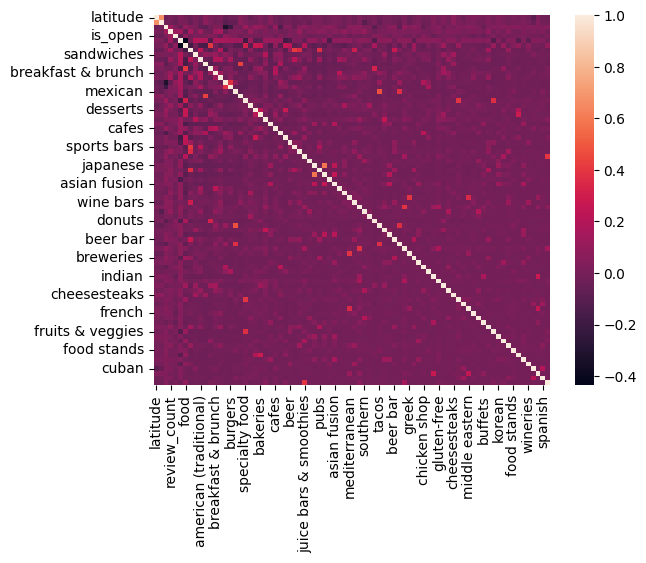

In [27]:
sns.heatmap(restaurants_dummies.corr())

## - Pearson 

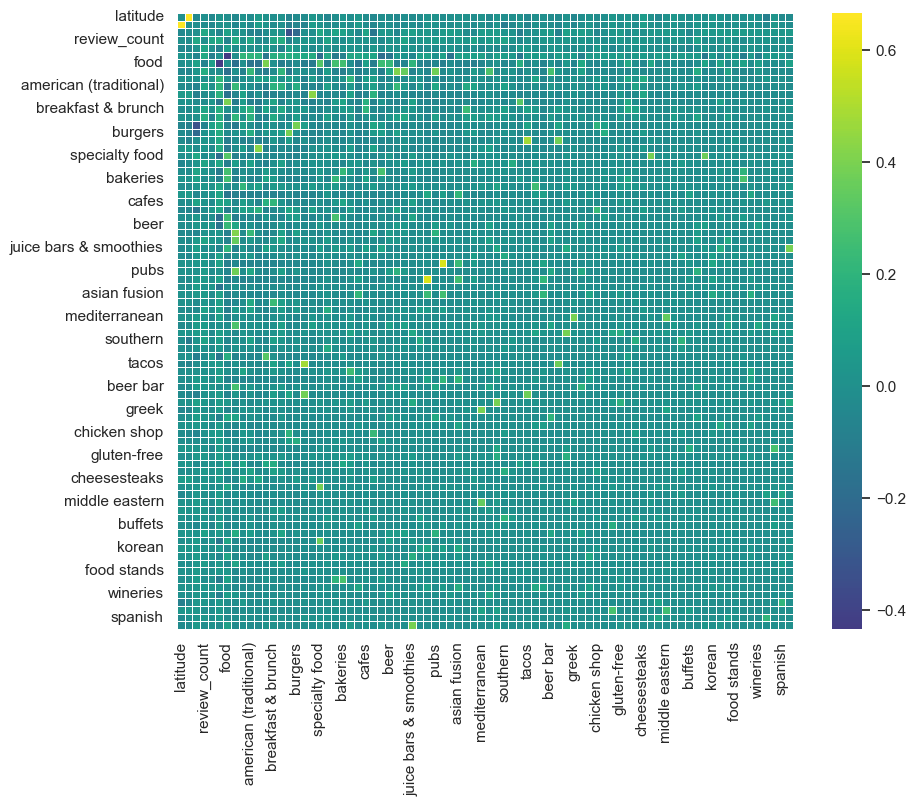

0

In [31]:
get_corr_matrix(dataset = restaurants_dummies,
                metodo = 'pearson', size_figure = [10,8])

In [46]:
#correlations
corr = restaurants_dummies[numericas].corr('pearson')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1)
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.3]

,level_0,level_1,correlation
80,longitude,latitude,0.666352
2752,sushi bars,japanese,0.585269
3616,tacos,mexican,0.478985
485,food,restaurants,0.433986
1370,italian,pizza,0.429781
2247,sports bars,bars,0.409112
886,coffee & tea,food,0.398802
4119,greek,mediterranean,0.392318
6350,acai bowls,juice bars & smoothies,0.391527
4898,ethnic food,specialty food,0.389561


In [48]:
restaurants_dummies[categoricas].head()

,business_id,name,address,city,state,postal_code
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015
3,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207
4,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602


# 7. Preprocessor

In [19]:
#Defining the steps in the numerical pipeline 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

#Defining the steps in the categorical pipeline 
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    
#Numerical features to pass down the numerical pipeline 
numeric_features = restaurants_dummies.select_dtypes(include=['int64', 'float64']).columns

#Categrical features to pass down the categorical pipeline 
categorical_features = restaurants_dummies.select_dtypes(include=['object']).columns

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# 8. Split in train and test

In [53]:
from sklearn.model_selection import train_test_split


x = restaurants_dummies.drop('stars', axis=1)
y = restaurants_dummies['stars']

#Split in train and test
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=12345)

In [54]:
#Train
pd.concat([xtrain, pd.DataFrame(ytrain)]).describe().round(3)

,latitude,longitude,review_count,is_open,restaurants,food,bars,sandwiches,american (traditional),pizza,coffee & tea,breakfast & brunch,american (new),fast food,burgers,mexican,italian,specialty food,seafood,desserts,bakeries,salad,chinese,cafes,chicken wings,ice cream & frozen yogurt,beer,sports bars,cocktail bars,juice bars & smoothies,barbeque,japanese,pubs,sushi bars,local flavor,asian fusion,diners,steakhouses,mediterranean,wine bars,vegetarian,southern,cajun/creole,donuts,tacos,soup,thai,beer bar,tex-mex,vegan,greek,breweries,vietnamese,chicken shop,hot dogs,indian,gluten-free,bagels,comfort food,cheesesteaks,ethnic food,caribbean,middle eastern,french,soul food,buffets,gastropubs,fruits & veggies,korean,bubble tea,tapas/small plates,food stands,cupcakes,noodles,wineries,cuban,halal,spanish,acai bowls,stars
count,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.00,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000,26278.000
mean,35.208,-79.698,75.255,0.683,0.783,0.415,0.164,0.131,0.123,0.111,0.103,0.095,0.096,0.081,0.076,0.059,0.074,0.062,0.056,0.050,0.046,0.046,0.046,0.044,0.043,0.042,0.034,0.031,0.024,0.027,0.026,0.028,0.027,0.028,0.019,0.025,0.022,0.022,0.022,0.016,0.019,0.017,0.006,0.018,0.014,0.015,0.017,0.015,0.014,0.014,0.014,0.012,0.011,0.013,0.012,0.014,0.011,0.013,0.01,0.014,0.010,0.012,0.010,0.008,0.008,0.008,0.008,0.009,0.008,0.008,0.007,0.007,0.006,0.005,0.003,0.007,0.007,0.006,0.006,3.554
std,5.442,4.573,166.491,0.465,0.412,0.493,0.371,0.338,0.329,0.314,0.304,0.293,0.294,0.273,0.264,0.235,0.263,0.241,0.230,0.219,0.209,0.210,0.209,0.205,0.204,0.200,0.182,0.174,0.152,0.163,0.158,0.165,0.162,0.164,0.136,0.156,0.146,0.147,0.146,0.126,0.138,0.129,0.080,0.134,0.118,0.123,0.128,0.120,0.117,0.116,0.119,0.110,0.104,0.111,0.107,0.116,0.106,0.111,0.10,0.118,0.099,0.110,0.097,0.087,0.090,0.090,0.091,0.096,0.090,0.089,0.082,0.081,0.079,0.074,0.058,0.084,0.082,0.076,0.075,0.854
min,27.555,-90.075,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
25%,28.045,-82.729,12.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000
50%,36.305,-82.271,28.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00

In [55]:
#Test
pd.concat([xtest, pd.DataFrame(ytest)]).describe().round(3)

,latitude,longitude,review_count,is_open,restaurants,food,bars,sandwiches,american (traditional),pizza,coffee & tea,breakfast & brunch,american (new),fast food,burgers,mexican,italian,specialty food,seafood,desserts,bakeries,salad,chinese,cafes,chicken wings,ice cream & frozen yogurt,beer,sports bars,cocktail bars,juice bars & smoothies,barbeque,japanese,pubs,sushi bars,local flavor,asian fusion,diners,steakhouses,mediterranean,wine bars,vegetarian,southern,cajun/creole,donuts,tacos,soup,thai,beer bar,tex-mex,vegan,greek,breweries,vietnamese,chicken shop,hot dogs,indian,gluten-free,bagels,comfort food,cheesesteaks,ethnic food,caribbean,middle eastern,french,soul food,buffets,gastropubs,fruits & veggies,korean,bubble tea,tapas/small plates,food stands,cupcakes,noodles,wineries,cuban,halal,spanish,acai bowls,stars
count,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.00,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000,6570.000
mean,35.235,-79.727,76.019,0.687,0.782,0.411,0.163,0.125,0.127,0.110,0.095,0.094,0.095,0.079,0.071,0.054,0.073,0.065,0.059,0.045,0.044,0.048,0.047,0.043,0.043,0.038,0.037,0.033,0.023,0.028,0.027,0.031,0.026,0.032,0.022,0.023,0.024,0.022,0.021,0.016,0.019,0.019,0.007,0.017,0.013,0.016,0.019,0.014,0.012,0.015,0.017,0.012,0.01,0.014,0.011,0.012,0.012,0.011,0.012,0.012,0.011,0.010,0.009,0.007,0.009,0.008,0.008,0.008,0.006,0.006,0.007,0.006,0.007,0.007,0.005,0.008,0.005,0.007,0.006,3.566
std,5.427,4.589,145.534,0.464,0.413,0.492,0.369,0.331,0.333,0.313,0.293,0.292,0.293,0.269,0.256,0.226,0.261,0.247,0.235,0.207,0.206,0.215,0.212,0.203,0.202,0.192,0.188,0.180,0.150,0.165,0.161,0.173,0.159,0.176,0.147,0.151,0.154,0.148,0.142,0.126,0.136,0.138,0.084,0.128,0.114,0.126,0.136,0.116,0.109,0.122,0.128,0.110,0.10,0.116,0.103,0.109,0.109,0.102,0.111,0.107,0.102,0.101,0.094,0.083,0.094,0.088,0.088,0.087,0.077,0.078,0.081,0.080,0.085,0.081,0.072,0.089,0.072,0.081,0.076,0.844
min,27.564,-87.115,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
25%,28.048,-82.729,12.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000
50%,36.304,-82.291,29.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500
75%,40.004,-75.181

# 9. Save the data

In [62]:
#Save the dataframes
xtrain.to_parquet("../data/processed/xtrain.parquet")
xtest.to_parquet("../data/processed/xtest.parquet")
pd.DataFrame(ytrain).to_parquet("../data/processed/ytrain.parquet")
pd.DataFrame(ytest).to_parquet("../data/processed/ytest.parquet")
restaurants_dummies.to_parquet("../data/processed/restaurant.parquet")

Now we are going to realize in other notebook the models in function the new split of the data.